In [2]:
import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import qiskit as qk
from IPython.display import display
from qiskit import IBMQ, pulse
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.providers.aer import PulseSimulator
from qiskit.compiler import assemble
from scipy.optimize import curve_fit
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

test_set= [1,0.5,0.25,2]

In [37]:
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147'

configrc.store_credentials:WARNING:2022-07-18 14:29:51,259: Credentials already present. Set overwrite=True to overwrite.


In [39]:
backend = provider.get_backend("ibmq_jakarta")

## Functions

In [54]:
def State_vec_tomography(circ, backend):
    #actual state calculation
    q2 = QuantumRegister(1)
    state = QuantumCircuit(q2)
    state.x(q2[0])
    job = qk.execute(state, backend=Aer.get_backend('statevector_simulator'))
    state_results = job.result().get_statevector(state)
    t = time.time()
    test_circ = state_tomography_circuits(circ,[0])
    job = qk.execute(test_circ, backend=backend, shots=8192)
    test_state = StateTomographyFitter(job.result(), test_circ).fit()
    Fidelity = state_fidelity(state_results,test_state)
    print('Time taken:', time.time() - t)
    return Fidelity
    
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    error = np.sqrt(np.diag(conv))
    return fitparams, y_fit, error

def run_jobs(circs,tag, backend,shots):
    count = 0
    chunk_size = backend.configuration().max_experiments
    jobs = []
    temp=[]
    id_str = []
    for i,j in enumerate(circs):
        print(i)
        temp.append(j)
        id_str.append(tag+"__"+str(i))
        if ((i+1)%chunk_size == 0 or (i+1)==len(circs)):
            jobs.append(backend.run(temp,job_tags=id_str,shots=shots))
            temp = []
            id_str = [] 
    job_monitor(jobs[-1])
    results = []
    for i in jobs:
        results+=backend.retrieve_job(i)
    return jobs, results

In [52]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer
from qiskit.providers.ibmq.managed import IBMQJobManager

noise_power = 1e-3
num_noise_trajs = 30

def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

def parametrize_circ(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)/64))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            for j in range(int(len(circ)/64)):
                pulse.play(circ[j*64:(j+1)*64], pulse.drive_channel(0))
                pulse.shift_phase(par[j],pulse.drive_channel(0))
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        for i in range(len(par)):
            temp.assign_parameters({par[i]: traj[i]}, inplace=True)
        batch.append(temp)
    return batch

def parametrize_circ_1(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            for j in range(int(len(circ))):
                pulse.play([circ[j] for p in range(64)], pulse.drive_channel(0))
                pulse.shift_phase(par[j],pulse.drive_channel(0))
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        for i in range(len(par)):
            temp.assign_parameters({par[i]: traj[i]}, inplace=True)
        batch.append(temp)
    return batch

def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list

shots=1000

def Spec(data,start,end,num_center_freqs=100,backend=backend, option = 0):  
    #option 0 beaks upp pulse into 64dt chuncks option 1 will extend pulses to 64dt
    if(option):
        num_gates=int(len(data))
    else:
        num_gates=int(len(data)/64)
    circ_batch = []
    center_idxs=[]
    centers=[]
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
        #print('Probing Filter Function at Normalized Frequency: ', center)
        # Generate noise trajectories
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = np.array(schwarma_trajectories(a, b, num_gates, num_noise_trajs))
    
        # Build noisy circuit dictionary
        if(not option):
            circ_batch+=(parametrize_circ(data,noise_traj_list,backend))
        else:
            circ_batch+=(parametrize_circ_1(data,noise_traj_list,backend))

        # Run circuits
    job_manager = IBMQJobManager()
    jobs, results = run_jobs(circ_batch, backend=backend,tag=('Spectrosopy'+str(time.strftime("%H:%M:%S", time.localtime()))),shots=shots)
    

    # Compile Results
    cc=0
    prob = 0
    counter = 0
    for i in range(int(len(circ_batch)/num_noise_trajs)):
        for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)]:
            zero_counts = results.get_counts(cc).get('1')
            prob += zero_counts/shots
            cc+=1
        prob = prob/num_noise_trajs
        all_probs[int(center_idxs[counter]), :] = centers[counter], prob
        counter+=1
        prob=0
    
    return all_probs, circ_batch

## test

In [44]:
test=np.array([np.sqrt(i)] for i in range(64))
signal = Custom_Fgp('low_freq',test,backend)
#print(signal.input)
#print(signal.norm)
signal.draw()

TypeError: unsupported operand type(s) for /: 'generator' and 'generator'

In [ ]:
test=np.array([np.sqrt(i) for i in range(64)])
print(np.abs(test).max())
test= test/test.max()
t = time.time()
start=0.3
end=start+((0.98-0.02)/10)
all_probs, circ_batch= Spec(test,0.02,0.98,100,backend=backend,option=1)
circ_batch[2].draw()

Text(0.5, 0, 'Center Frequency')

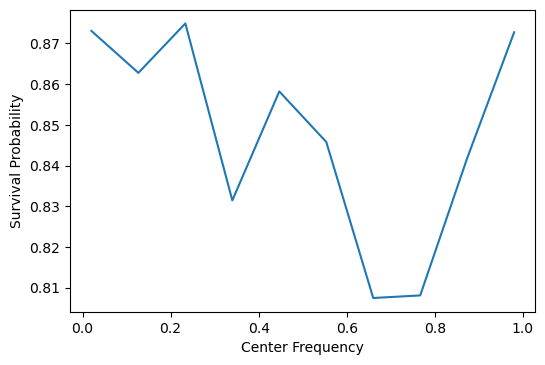

In [110]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_probs[:,0], all_probs[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [ ]:
temp = range(27)
jobs = run_jobs(temp,1)
jobs

## Main struct class

In [41]:
class Custom_Fgp:
    def __init__(self, name, inp,backend):
        self.name=name
        self.input = np.array(inp)
        self.backend = backend
        drive_sigma_sec = 0.015 * 1.0e-6                          # This determines the actual width of the gaussian
        drive_duration_sec = drive_sigma_sec   
        #self.norm = self.input/np.sqrt((self.input**2).sum())
        self.norm = self.input/self.input.max()
        self.par = Parameter('drive_amp')
        self.length = 1
        self.pi_p,plt = self.full_cal()
    
    #replaced using Customize_pulse_2)
    def Create_Pulse(self):
        temp = []
        for i in self.norm:
            for j in range(int(self.length)):
                temp.append(i)
        temp = np.array(temp)
        with pulse.build(backend=self.backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(temp*self.pi_p, pulse.drive_channel(0))]
        return custom_Pulse
    
    def Customize_pulse(self,x):
        with pulse.build(backend=self.backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(self.norm*x, pulse.drive_channel(0))]
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        return custom_Pulse
    
    def Customize_pulse_2(self, x, length):
        temp = []
        for i in self.norm:
            for j in range(int(length)):
                temp.append(i)
        temp = np.array(temp)
        with pulse.build(backend=self.backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(temp*x, pulse.drive_channel(0))]
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        return custom_Pulse
    
    def draw(self):
        return self.Customize_pulse_2(1,self.length).draw(backend=self.backend)
    
    def baseline_remove(self, values):
        return np.array(values) - np.mean(values)
    
    '''def rabi_test(self,num_rabi_points): #non functional
        scale_factor = 1e-15
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.cont.assign_parameters({self.par: a}, inplace=False) for a in drive_amps]
        num_shots_per_point = 1024
        job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
        job_monitor(job)
        
        rabi_results = job.result(timeout=120)
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))

        return drive_amps,rabi_values'''
    
    def Cali(self,num_rabi_points,length):
        scale_factor = 1e-15
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.Customize_pulse_2(a,length) for a in drive_amps]
        #return rabi_schedules
        num_shots_per_point = 1024
        job = self.backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
        job_monitor(job)
        
        rabi_results = job.result(timeout=120)
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))

        return drive_amps,rabi_values
    
    def full_cal(self):
        scale_factor = 1e-15
        num_rabi_points = 10
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
        pi_amp = 2
        counter = 0
        error_counter=0
        error= [np.inf,np.inf,np.inf]
        while pi_amp > 0.9:
            counter+=1
            if counter==100:
                break
            drive_amps,rabi_values = self.Cali(num_rabi_points,counter)
            if(error[1]==np.inf):
                error_counter=0
                while (error[1]==np.inf):
                    fit_params, y_fit, error = fit_function(drive_amps,
                                         rabi_values, 
                                         lambda x, A, drive_period, phi:(A*np.sin(2*np.pi*x/drive_period - phi)),
                                         [-(np.max(rabi_values)-np.min(rabi_values))/2, test_set[error_counter], 0])
                    #print(error_counter, ": ",test_set[error_counter] , ": " , error)
                    if((error[1] == np.inf) and error_counter<3):
                        error_counter+=1
                    else:
                        break
            else:
                fit_params, y_fit, error = fit_function(drive_amps,
                                         rabi_values, 
                                         lambda x, A, drive_period, phi:(A*np.sin(2*np.pi*x/drive_period - phi)),
                                         [-(np.max(rabi_values)-np.min(rabi_values))/2, test_set[error_counter], 0])
            drive_period = fit_params[1]
            pi_amp = abs(drive_period / 2)
            print(counter, "L: ", pi_amp)
        self.length = counter
        drive_amps,rabi_values = self.Cali(50,counter)
        fit_params, y_fit, error = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi:(A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                  [-(np.max(rabi_values)-np.min(rabi_values))/2,0, test_set[error_counter], 0])
        drive_period = fit_params[2]
        pi_amp = abs(drive_period / 2)
        plt.scatter(drive_amps, rabi_values, color='black')
        plt.plot(drive_amps, y_fit, color='red')
        print(fit_params)
        drive_period = fit_params[2] # get period of rabi oscillation

        plt.axvline(0, color='red', linestyle='--')
        plt.axvline(drive_period/2, color='red', linestyle='--')
        plt.annotate("", xy=(0, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
        plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

        plt.xlabel("Drive len [dt]", fontsize=15)
        plt.title(str(self.backend), fontsize=15)
        plt.ylabel("Measured signal [a.u.]", fontsize=15)
        plt.show()
        return pi_amp,plt
    
    def Cali_l(self,len_max):
        scale_factor = 1e-15
        drive_len = np.linspace(1,len_max,len_max-1)

        rabi_schedules = [self.Customize_pulse_2(1,a) for a in drive_len]
        #return rabi_schedules
        num_shots_per_point = 1024
        job = self.backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
        job_monitor(job)
        
        rabi_results = job.result(timeout=120)
        rabi_values = []
        for i in range(len_max-1):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))

        return drive_len,rabi_values
        
    def rabi_test_Sim(self, num_rabi_points,length):
        scale_factor = 1e-15
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.Customize_pulse_2(a,length) for a in drive_amps]
        #return rabi_schedules
        num_shots_per_point = 1024
        armonk_model = PulseSystemModel.from_backend(self.backend)
        backend_sim = PulseSimulator(system_model=armonk_model)

        rabi_qobj = assemble(rabi_schedules, 
                             backend=backend_sim,
                             meas_level=1, 
                             meas_return='avg',
                             shots=num_shots_per_point)
        sim_result = backend_sim.run(rabi_qobj).result()
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(sim_result.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))
        return drive_amps,rabi_values
    
    def add_as_gate(self,circ,qubits):
        custom_gate = Gate(self.name, 1,[])
        [circ.append(custom_gate, [i]) for i in qubits]
        circ.add_calibration(self.name, qubits, self.Create_Pulse(), [])
        return circ
    
    def Full_tomography():
        return 0